In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [19]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int


In [7]:
import os

# using groq api
open_ai_key = os.getenv('OPEN_API_KEY')
open_ai_base_url = "https://api.groq.com/openai/v1"
model = ChatOpenAI(model = 'llama3-8b-8192', api_key=open_ai_key, base_url=open_ai_base_url)

### Define the prompts

In [8]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [9]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [10]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [11]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [ ]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


### defining all the nodes

In [13]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [16]:
%pip install tavily-python

Note: you may need to restart the kernel to use updated packages.


In [18]:
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key = os.environ["TAVILY_API_KEY"])

In [20]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [50]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r['content'])
    return {'content': content}

In [51]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content = f"{state['task']}\n\nHere is my plan: \n\n{state['plan']}"
    )
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [24]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [ ]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get("content", [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r['content'])
    return {'content': content}

In [26]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

### Putting all together

In [52]:
builder = StateGraph(AgentState)

In [53]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [54]:
builder.set_entry_point("planner")

In [55]:
builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

In [56]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [61]:
graph =  builder.compile(checkpointer=memory)

### Visualize the graph

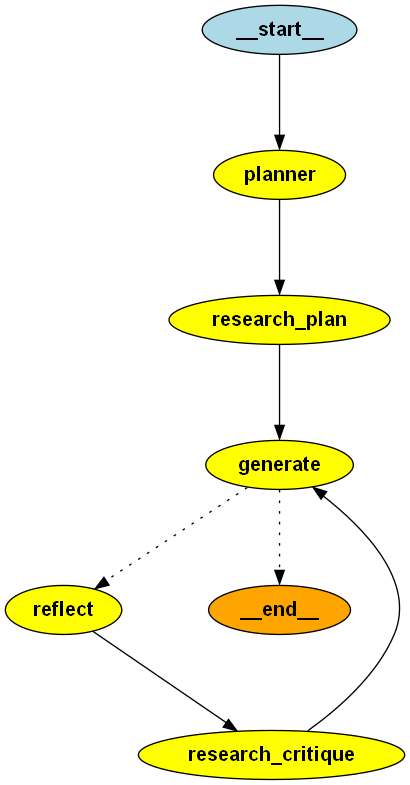

In [ ]:
# visualize the agent
from IPython.display import Image

Image(graph.get_graph().draw_png())

### running our agent

In [62]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1
}, thread):
    print(s)

{'planner': {'plan': 'Here is a suggested outline for an essay on the differences between LangChain and Langsmith:\n\nI. Introduction\n\n* Briefly introduce the topic and provide context on the rise of AI-powered language generation tools\n* Thesis statement: LangChain and LangSmith are two AI-powered language generation platforms that share some similarities, but have distinct differences in their approaches, strengths, and applications.\n\nII. Background on LangChain and LangSmith\n\n* Provide a brief overview of each platform, including their core technologies, features, and use cases\n* LangChain notes:\n\t+ Focus on generating coherent and logical text based on input prompts\n\t+ Use a combination of natural language processing and machine learning algorithms\n\t+ Strengths: good at generating logical and coherent text, helpful for tasks that require reasoning and deduction\n\t+ Weaknesses: may struggle with creative writing or tasks that require emotional expression\n\nLangSmith 

c:\Users\hp\anaconda3\envs\py3.9\lib\site-packages\langchain_openai\chat_models\base.py:1534: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['Here’s the deal: LangChain is like building the entire car, while LangSmith is your diagnostic tool to ensure that car runs smoothly. When it comes to practical application, I always say: “Show, don’t tell.” I’ve used both LangChain and LangSmith extensively, and I’ve found that they complement each other beautifully when you’re building and fine-tuning LLM-based workflows. Having spent countless hours building and debugging LLM-based systems, I’ve learned that using LangChain and LangSmith effectively requires a few smart strategies. I often use LangChain to build my pipelines and LangSmith to monitor and debug them. Start with LangChain to build your pipeline, and then bring in LangSmith to ensure it performs as expected.', 'LangChain is an open-source framework designed to streamline the development of applications leveraging language models. It offers modular components to connect various tasks, enabling a seamless']}}
{'generate': {'draft': "Based o

c:\Users\hp\anaconda3\envs\py3.9\lib\site-packages\langchain_openai\chat_models\base.py:1534: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_critique': {'content': ['Here’s the deal: LangChain is like building the entire car, while LangSmith is your diagnostic tool to ensure that car runs smoothly. When it comes to practical application, I always say: “Show, don’t tell.” I’ve used both LangChain and LangSmith extensively, and I’ve found that they complement each other beautifully when you’re building and fine-tuning LLM-based workflows. Having spent countless hours building and debugging LLM-based systems, I’ve learned that using LangChain and LangSmith effectively requires a few smart strategies. I often use LangChain to build my pipelines and LangSmith to monitor and debug them. Start with LangChain to build your pipeline, and then bring in LangSmith to ensure it performs as expected.', 'LangChain is an open-source framework designed to streamline the development of applications leveraging language models. It offers modular components to connect various tasks, enabling a seamless', 'Technical documentation soft

In [63]:
# final output
current_state = graph.get_state(thread)

In [69]:
print(current_state.values['task'])
print()
print(current_state.values['draft'])

what is the difference between langchain and langsmith

Here is a 5-paragraph essay based on the provided outline:

Unlike other AI-powered language generation tools, LangChain and LangSmith differentiate themselves through their approaches, strengths, and applications. LangChain is a more logical and coherent platform, utilizing natural language processing and machine learning algorithms to generate text based on input prompts. Its strengths lie in tasks that require reasoning and deduction, making it an excellent tool for generating technical writing, such as technical documentation or news articles. However, LangChain may struggle with creative writing or tasks that demand emotional expression.

On the other hand, LangSmith focuses on generating creative and engaging text, combining natural language processing, machine learning, and generative adversarial networks (GANs). Its strengths are evident in tasks that require imagination and flair, such as fiction or blog posts. LangSmith 